In [143]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer
from models.audio_encoder import AudioEncoder
from models.embed import TextEmbedding
from models.forward_diffusion import Diffusion
from dataset.char_tokenization import CharacterTokenization
from dataset.conversion_utils import SpeechConverter
from utils.consts import NUM_MELS, SYMBOLS
from IPython.display import Audio
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.decomposition import PCA

### Loading streaming dataset from hf


In [144]:

def load_librispeech_samples(num_samples=5, split="test.clean"):
    samples = []
    srs = []
    texts = []

    print(f"Loading {num_samples} samples from LibriSpeech {split} (streaming)...")
    ds = load_dataset("openslr/librispeech_asr", split=split, streaming=True)
    for i, item in enumerate(ds):
        if i >= num_samples:
            break

        audio_array = torch.tensor(item['audio']['array'], dtype=torch.float32)
        sample_rate = item['audio']['sampling_rate']
        text = item['text']

        samples.append(audio_array)
        texts.append(text)
        srs.append(sample_rate)
    return samples, texts, srs


In [145]:
audio_encoder = AudioEncoder(in_channels=1, dropout=0.1)
text_embedding = TextEmbedding(vocab_size=len(SYMBOLS), embed_dim=128, max_seq_len=512)
diffusion = Diffusion(sde_type="VE", min_sigma=0.1, max_sigma=50.0)

tokenizer = CharacterTokenization()
speech_converter = SpeechConverter(num_mels=NUM_MELS)


emb work


In [146]:
sample_audios, sample_texts, srs = load_librispeech_samples(num_samples=5, split="test.clean")

Loading 5 samples from LibriSpeech test.clean (streaming)...


In [147]:
Audio_1 = Audio(sample_audios[0], rate=srs[0])
Audio_1

In [148]:
sample_texts[0]

'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS'

In [149]:
Audio_2 = Audio(sample_audios[1], rate=srs[1])
Audio_2

In [150]:
sample_texts[1]

'THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY'

In [151]:
Audio_3 = Audio(sample_audios[2], rate=srs[2])
Audio_3

In [152]:
sample_texts[2]

'CONGRATULATIONS WERE POURED IN UPON THE PRINCESS EVERYWHERE DURING HER JOURNEY'

In [153]:
Audio_4 = Audio(sample_audios[3], rate=srs[3])
Audio_4

In [154]:
sample_texts[3]

'FROM THE RESPECT PAID HER ON ALL SIDES SHE SEEMED LIKE A QUEEN AND FROM THE ADORATION WITH WHICH SHE WAS TREATED BY TWO OR THREE SHE APPEARED AN OBJECT OF WORSHIP THE QUEEN MOTHER GAVE THE FRENCH THE MOST AFFECTIONATE RECEPTION FRANCE WAS HER NATIVE COUNTRY AND SHE HAD SUFFERED TOO MUCH UNHAPPINESS IN ENGLAND FOR ENGLAND TO HAVE MADE HER FORGET FRANCE'

In [155]:
Audio_5 = Audio(sample_audios[4], rate=srs[4])
Audio_5

In [156]:
sample_texts[4]

'SHE TAUGHT HER DAUGHTER THEN BY HER OWN AFFECTION FOR IT THAT LOVE FOR A COUNTRY WHERE THEY HAD BOTH BEEN HOSPITABLY RECEIVED AND WHERE A BRILLIANT FUTURE OPENED BEFORE THEM'

In [157]:
mel_specs = []
for i, audio in enumerate(sample_audios):

    mel_spec = speech_converter.convert_to_mel_spec(audio)
    mel_specs.append(mel_spec)
    print(f"Sample {i+1}: Mel spectrogram shape = {mel_spec.shape} (mels × time)")

    max_time = max(mel.shape[-1] for mel in mel_specs)
    padded_mel_specs = []
    for mel in mel_specs:

        pad_amount = max_time - mel.shape[-1]
        padded_mel = torch.nn.functional.pad(mel, (0, pad_amount), mode='constant', value=0)
        padded_mel_specs.append(padded_mel.unsqueeze(0)) #goes from bxmxt to bxcxmxt

    # 1 batch [B, C, Mels, Time]
    mel_batch = torch.stack(padded_mel_specs)
    print(f"Padded and batched mel spectrograms: {mel_batch.shape} [Batch, Channel, Mels, Time]")

Sample 1: Mel spectrogram shape = torch.Size([128, 220]) (mels × time)
Padded and batched mel spectrograms: torch.Size([1, 1, 128, 220]) [Batch, Channel, Mels, Time]
Sample 2: Mel spectrogram shape = torch.Size([128, 890]) (mels × time)
Padded and batched mel spectrograms: torch.Size([2, 1, 128, 890]) [Batch, Channel, Mels, Time]
Sample 3: Mel spectrogram shape = torch.Size([128, 315]) (mels × time)
Padded and batched mel spectrograms: torch.Size([3, 1, 128, 890]) [Batch, Channel, Mels, Time]
Sample 4: Mel spectrogram shape = torch.Size([128, 1458]) (mels × time)
Padded and batched mel spectrograms: torch.Size([4, 1, 128, 1458]) [Batch, Channel, Mels, Time]
Sample 5: Mel spectrogram shape = torch.Size([128, 692]) (mels × time)
Padded and batched mel spectrograms: torch.Size([5, 1, 128, 1458]) [Batch, Channel, Mels, Time]


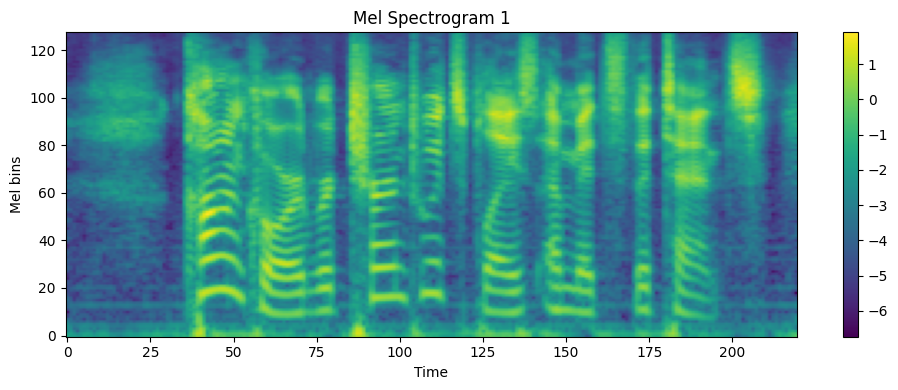

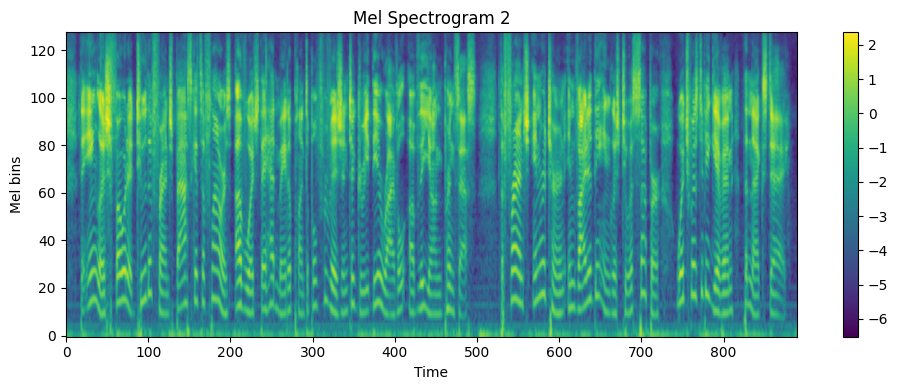

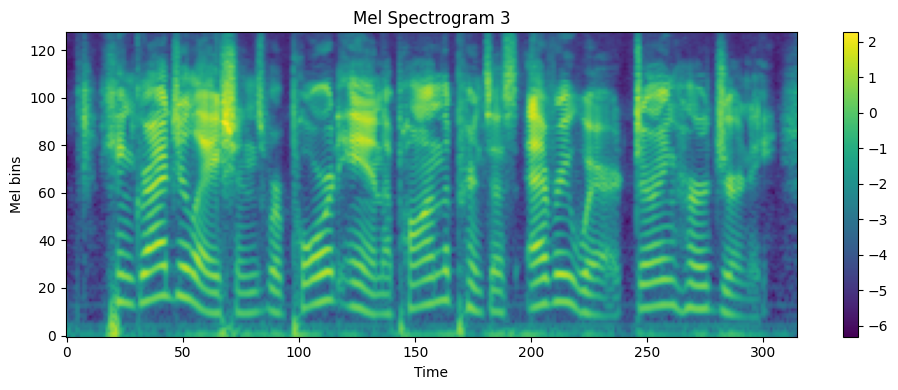

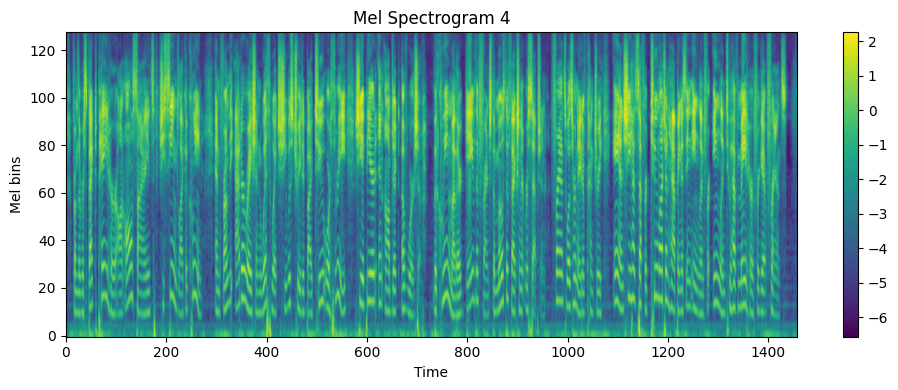

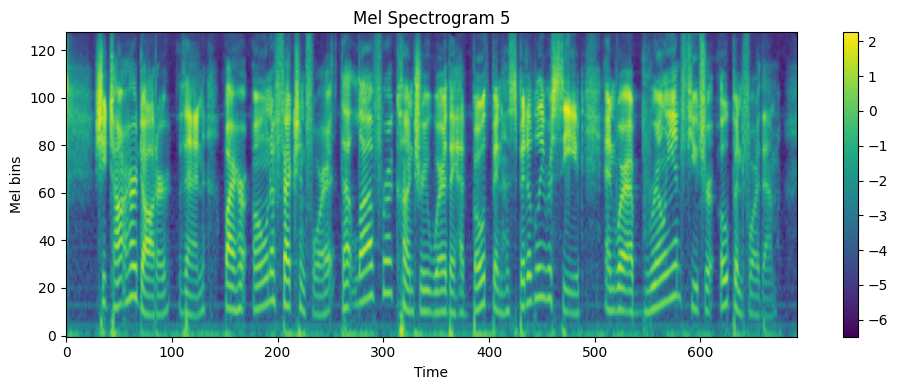

In [158]:
for i, mel in enumerate(mel_specs):
    mel_np = mel.cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_np, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f"Mel Spectrogram {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Mel bins")
    plt.tight_layout()
    plt.show()


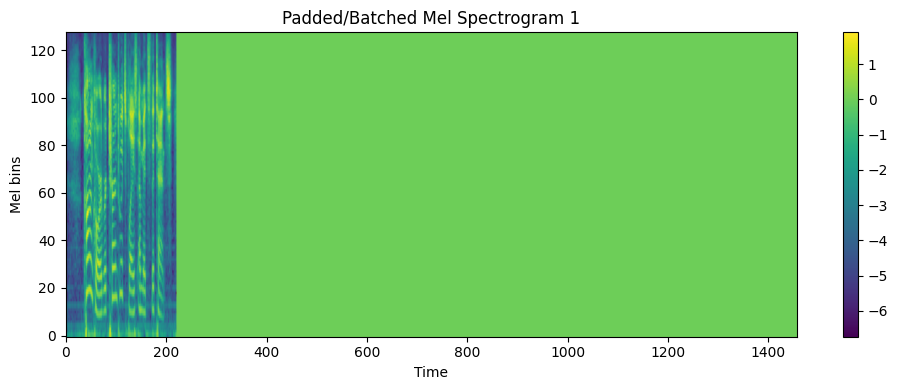

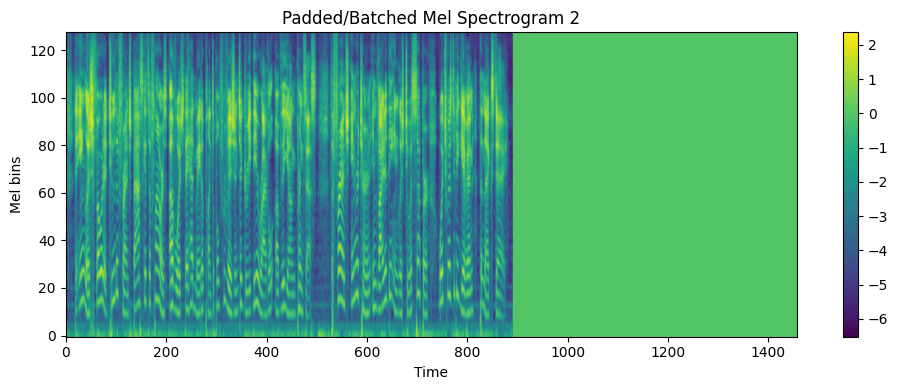

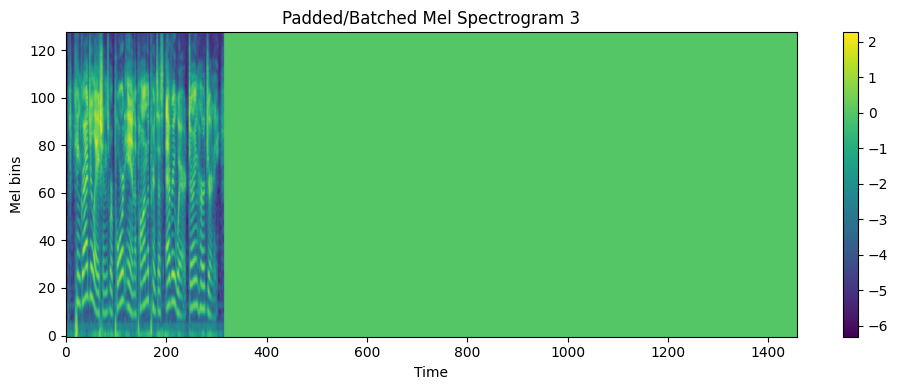

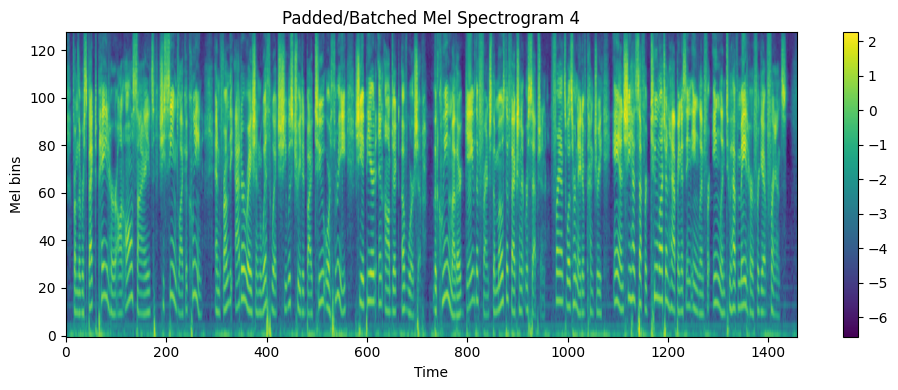

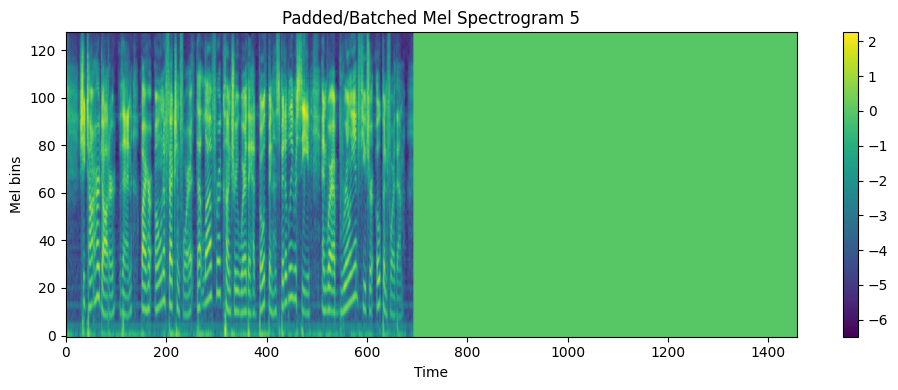

In [159]:
for i, mel in enumerate(mel_batch):
    mel_np = mel.squeeze(0).cpu().numpy()

    plt.figure(figsize=(10, 4))
    plt.imshow(mel_np, aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f"Padded/Batched Mel Spectrogram {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Mel bins")
    plt.tight_layout()
    plt.show()

### padding them all to the largest one's time


In [160]:
audio_encoder.eval()
with torch.no_grad():
    encoded_audio = audio_encoder(mel_batch)

In [161]:
encoded_audio

tensor([[[[-4.8080e-02, -1.1225e-01, -1.1325e-01,  ..., -7.2101e-03,
           -7.2101e-03, -1.1133e-02],
          [ 3.2361e-02, -4.0414e-02, -4.0542e-02,  ..., -4.7004e-03,
           -4.7004e-03, -5.5494e-03],
          [ 6.7692e-02, -2.4818e-02,  1.1923e-02,  ..., -4.7004e-03,
           -4.7004e-03, -5.5494e-03],
          ...,
          [ 9.9075e-03, -6.8876e-02, -3.1253e-02,  ..., -4.7004e-03,
           -4.7004e-03, -5.5494e-03],
          [ 3.8147e-02, -8.1849e-02, -4.0432e-02,  ..., -4.7004e-03,
           -4.7004e-03, -5.5494e-03],
          [ 2.5813e-02, -5.5348e-02, -7.1708e-02,  ..., -4.7004e-03,
           -4.7004e-03, -5.5494e-03]],

         [[-1.1326e-02, -9.0698e-02, -5.2219e-02,  ..., -9.4693e-03,
           -9.4693e-03, -7.3935e-03],
          [ 1.6537e-01, -3.1964e-03,  5.3181e-03,  ..., -1.2113e-02,
           -1.2113e-02, -1.2075e-02],
          [ 2.2307e-01, -5.6237e-02, -2.6179e-02,  ..., -1.2113e-02,
           -1.2113e-02, -1.2075e-02],
          ...,
     

In [162]:
use_char_level = False

def char_level_tokenize(text, tokenizer):
    return tokenizer.text_to_seq_char_level(text)

hf_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def hf_tokenize(text, tokenizer):
    encoded = tokenizer(text, truncation=True, return_tensors='pt')
    return encoded['input_ids'].squeeze(0).tolist()

token_seqs = []
if use_char_level:
    token_seqs = [char_level_tokenize(text, tokenizer) for text in sample_texts]
else:
    token_seqs = [hf_tokenize(text, hf_tokenizer) for text in sample_texts]

max_len = max(len(seq) for seq in token_seqs)
num_emb = text_embedding.tok_emb.num_embeddings

padded_tokens = torch.zeros(len(token_seqs), max_len, dtype=torch.long)

for i, seq in enumerate(token_seqs):
    seq_tensor = torch.tensor(seq, dtype=torch.long)
    seq_tensor = torch.clamp(seq_tensor, max=num_emb - 1)
    padded_tokens[i, :len(seq_tensor)] = seq_tensor


text_embedding.eval()
with torch.no_grad():
    text_embeddings, _ = text_embedding(padded_tokens, mask=None)

print("Embeddings shape:", text_embeddings.shape)


Embeddings shape: torch.Size([5, 71, 128])


In [163]:
for text in sample_texts:
    print(text)
    print(hf_tokenizer(text))

CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS
{'input_ids': [101, 16557, 2513, 2000, 2049, 2173, 17171, 1996, 17732, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY
{'input_ids': [101, 1996, 2394, 2830, 2098, 2000, 1996, 2413, 25946, 1997, 4870, 1997, 2029, 2027, 2018, 2081, 1037, 20228, 4765, 18424, 9347, 2000, 17021, 1996, 5508, 1997, 1996, 2402, 4615, 1996, 2413, 1999, 2709, 4778, 1996, 2394, 2000, 1037, 15264, 2029, 2001, 2000, 2022, 2445, 1996, 2279, 2154, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
CONGRATULATIONS WERE POURED IN UPON THE PRINCESS EVERYWHERE DURING HER JOURNEY
{'input_ids': [101, 23156, 2020, 8542, 1999, 

In [164]:
timesteps = torch.tensor([0.2, 0.4, 0.6, 0.8, 0.95])

noised_embeddings, noise_eps, alpha_t, sigma_t = diffusion.add_noise(
        text_embeddings, timesteps, mask=None
    )
print(f"Noised embeddings shape: {noised_embeddings.shape}")
print(f"Noise coefficients (sigma_t): {[f'{s:.2f}' for s in sigma_t.tolist()]}")
print(f"Signal coefficients (alpha_t): {[f'{a:.3f}' for a in alpha_t.tolist()]}")


Noised embeddings shape: torch.Size([5, 71, 128])
Noise coefficients (sigma_t): ['0.35', '1.20', '4.16', '14.43', '36.65']
Signal coefficients (alpha_t): ['1.000', '1.000', '1.000', '1.000', '1.000']


### Needs work, but idea is there

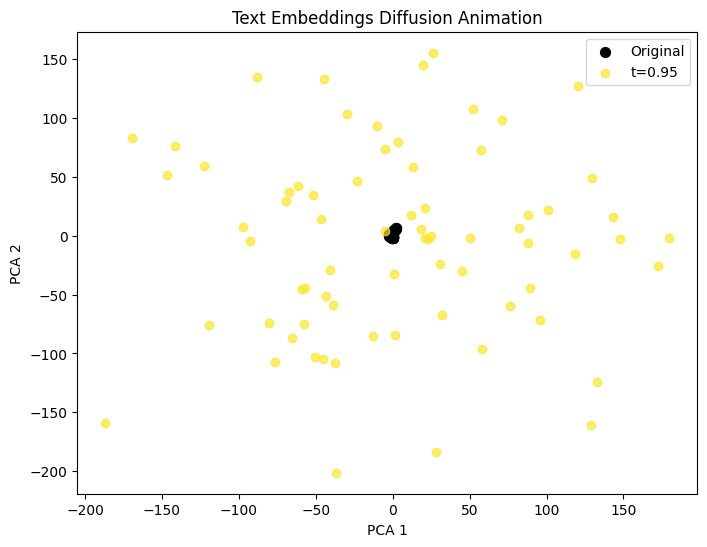

In [165]:

if isinstance(timesteps, int):
    timesteps = [timesteps]

if text_embeddings.ndim == 3:
    text_embeddings = text_embeddings[0]
seq_len, embed_dim = text_embeddings.shape

if noised_embeddings.ndim == 4:
    noised_embeddings = noised_embeddings[0]
num_timesteps = noised_embeddings.shape[0]

all_embeddings = torch.cat([text_embeddings.unsqueeze(0), noised_embeddings], dim=0)
all_embeddings_flat = all_embeddings.reshape(-1, embed_dim).numpy()
pca = PCA(n_components=2)
all_embeddings_2d = pca.fit_transform(all_embeddings_flat)
original_2d = all_embeddings_2d[:seq_len]
noised_2d = all_embeddings_2d[seq_len:].reshape(num_timesteps, seq_len, 2)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(original_2d[:, 0], original_2d[:, 1], c='black', s=50, label='Original')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_title("Text Embeddings Diffusion Animation")

colors = plt.cm.viridis(torch.linspace(0, 1, num_timesteps))

def update(frame):
    ax.clear()
    ax.scatter(original_2d[:, 0], original_2d[:, 1], c='black', s=50, label='Original')
    ax.scatter(noised_2d[frame][:, 0], noised_2d[frame][:, 1],
               color=colors[frame], alpha=0.7, label=f"t={timesteps[frame]:.2f}")
    ax.set_xlabel("PCA 1")
    ax.set_ylabel("PCA 2")
    ax.set_title("Text Embeddings Diffusion Animation")
    ax.legend()

ani = FuncAnimation(fig, update, frames=num_timesteps, interval=800)
ani.save('epic.gif')
plt.show()


In [166]:

for i, t in enumerate(timesteps):
        noise_ratio = sigma_t[i] / (alpha_t[i] + 1e-8)
        print(f"Sample {i+1} (t={t:.2f}): sigma/alpha = {noise_ratio:.2f}, noise_level={sigma_t[i].item()/50.0*100:.1f}%")

Sample 1 (t=0.20): sigma/alpha = 0.35, noise_level=0.7%
Sample 2 (t=0.40): sigma/alpha = 1.20, noise_level=2.4%
Sample 3 (t=0.60): sigma/alpha = 4.16, noise_level=8.3%
Sample 4 (t=0.80): sigma/alpha = 14.43, noise_level=28.9%
Sample 5 (t=0.95): sigma/alpha = 36.65, noise_level=73.3%


### Should be a NN, but for demo purposes uses ground truth
look at `models.forward_diffusion.py` for implmentation and derivation of this

In [167]:

reconstructed_embeddings = diffusion.denoise(
    noised_embeddings, noise_eps, alpha_t, sigma_t
)
reconstruction_error = torch.mean(torch.abs(text_embeddings - reconstructed_embeddings))
print(f"Mean reconstruction error: {reconstruction_error:.6f}")


Mean reconstruction error: 0.461590


In [168]:

for i in range(len(sample_texts)):
    orig_norm = torch.norm(text_embeddings[i], dim=-1).mean()
    recon_norm = torch.norm(reconstructed_embeddings[i], dim=-1).mean()
    cosine_sim = torch.nn.functional.cosine_similarity(
        text_embeddings[i], reconstructed_embeddings[i], dim=-1
    ).mean()

    text= sample_texts[i]
    print(f"  Sample {i+1}: '{text}'")
    print(f" Original embedding norm: {orig_norm:.4f}")
    print(f" Reconstructed norm: {recon_norm:.4f}")
    print(f" Cosine similarity: {cosine_sim:.4f}")


  Sample 1: 'CONCORD RETURNED TO ITS PLACE AMIDST THE TENTS'
 Original embedding norm: 13.9701
 Reconstructed norm: 14.1739
 Cosine similarity: 0.0150
  Sample 2: 'THE ENGLISH FORWARDED TO THE FRENCH BASKETS OF FLOWERS OF WHICH THEY HAD MADE A PLENTIFUL PROVISION TO GREET THE ARRIVAL OF THE YOUNG PRINCESS THE FRENCH IN RETURN INVITED THE ENGLISH TO A SUPPER WHICH WAS TO BE GIVEN THE NEXT DAY'
 Original embedding norm: 14.3869
 Reconstructed norm: 14.7397
 Cosine similarity: 0.4453
  Sample 3: 'CONGRATULATIONS WERE POURED IN UPON THE PRINCESS EVERYWHERE DURING HER JOURNEY'
 Original embedding norm: 14.6874
 Reconstructed norm: 14.2333
 Cosine similarity: 0.0181
  Sample 4: 'FROM THE RESPECT PAID HER ON ALL SIDES SHE SEEMED LIKE A QUEEN AND FROM THE ADORATION WITH WHICH SHE WAS TREATED BY TWO OR THREE SHE APPEARED AN OBJECT OF WORSHIP THE QUEEN MOTHER GAVE THE FRENCH THE MOST AFFECTIONATE RECEPTION FRANCE WAS HER NATIVE COUNTRY AND SHE HAD SUFFERED TOO MUCH UNHAPPINESS IN ENGLAND FOR ENG